# Learning how to compute time derivatives

## Differentiation methods
This notebook explores various choices of differentiation methods that can be used with PyKoopman's `KoopmanContinuous` class.

The optional parameter `differentiator` of the `KoopmanContinuous` class allows one to pass in custom time differentiation methods. `differentiator` should be callable with the call signature `differentiator(x, t)` where `x` is a 2D numpy `ndarray` with each example occupying a *row* and `t` is a 1D numpy `ndarray` containing the points in time for each row in `x`.

Two common options for `differentiator` are 1) Methods from the [derivative](https://derivative.readthedocs.io/en/latest/) package, called via the `pykoopman.differentiation.Derivative` wrapper. 2) Entirely custom methods.

In [1]:
from platform import python_version
python_version() 

'3.10.9'

In [2]:
from derivative import dxdt
import matplotlib.pyplot as plt
import numpy as np

import pykoopman as pk
from pydmd import DMD

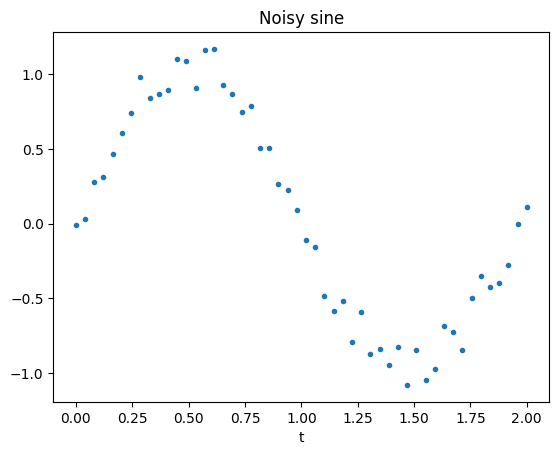

In [3]:
t = np.linspace(0, 2, 50)
x = np.sin(np.pi * t) + 0.1 * np.random.standard_normal(t.shape)
x_dot = np.pi * np.cos(np.pi *  t)

plt.plot(t, x, '.')
plt.xlabel('t')
plt.title('Noisy sine');

## Derivative package

All of the robust differentiation methods in the [derivative](https://derivative.readthedocs.io/en/latest/) package are available with the `pykoopman.differentiation.Derivative` wrapper class. One need only pass in the same keyword arguments to `Derivative` that one would pass to [derivative.dxdt](https://derivative.readthedocs.io/en/latest/api.html#dxdt-functional-interface).

For example, we'll compute the derivative of a noisy sine function with `dxdt` and `Derivative` using spline-based numerical differentiation and compare the results.

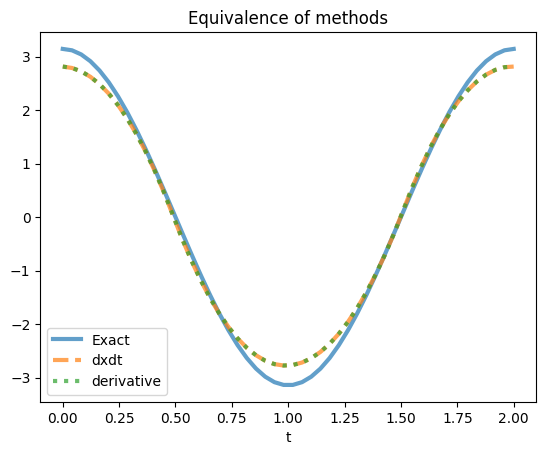

In [4]:
kws = dict(kind='spline', s=0.7, periodic=True)
x_dot_dxdt = dxdt(x, t, **kws)
x_dot_derivative = pk.differentiation.Derivative(**kws)(x, t)

plot_kws = dict(alpha=0.7, linewidth=3)
plt.plot(t, x_dot, label='Exact', **plot_kws)
plt.plot(t, x_dot_dxdt, '--', label='dxdt', **plot_kws)
plt.plot(t, x_dot_derivative, ':', label='derivative', **plot_kws)
plt.xlabel('t')
plt.title('Equivalence of methods')
plt.legend();

## Custom differentiation method

We also have the option of defining a fully custom differentiation function. Here we'll wrap numpy's `gradient` method. We can pass this method into  the `differentiator` argument of a `KoopmanContinuous` object.

In [5]:
from numpy import gradient

def diff(x, t):
    return gradient(x, axis=0)

In [6]:
dmd = DMD(svd_rank=2)
model = pk.KoopmanContinuous(differentiator=diff, regressor=dmd)
model.fit(x, dt=t[1]-t[0])

KoopmanContinuous(differentiator=<function diff at 0x000002CB75B41D80>,
                  observables=Identity(),
                  regressor=PyDMDRegressor(regressor=<pydmd.dmd.DMD object at 0x000002CB486DAC20>))